## <font color=darkorange> Logistic regression & Feed forward neural networks</font>

In [4]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# Required packages
np.set_printoptions(precision=2) 
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
from numpy.linalg import norm
from scipy.optimize import check_grad
import seaborn as sns

## <font color=darkred>Logistic regression </font>

### <font color=darkred>  Model </font>

$\rightharpoondown$ The objective is to predict the  label $Y\in\{0,1\}$ based on $X\in\mathbb{R}^d$.

$\rightharpoondown$ Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle + b)\,,
\end{equation*}
where $w \in \mathbb{R}^d$ is a vector of model weights and $b \in \mathbb{R}$ is the intercept, and where $\sigma$ is the sigmoid function.

$$
\sigma: z \mapsto \frac{1}{1 + e^{-z}}\,.
$$

$\rightharpoondown$ The sigmoid function is a \alert{model choice to map $\mathbb{R}$ into $(0,1)$}.

In [7]:
def sigmoid(x):
    expx = np.exp(x)
    z   = expx / (1. + expx)
    return z

def sample_logistic(w0, n_samples=1000, corr=0.5):
    n_features = w0.shape[0]
    cov        = toeplitz(corr ** np.arange(0, n_features))
    X          = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p          = sigmoid(X.dot(w0))
    y          = np.random.binomial(1, p, size=n_samples) # Play with a coin, probability of head is sigmoid
    return X, y

<font color=darkred>  Prove that the Bayes classifier is linear in the logistic regression setting</font>

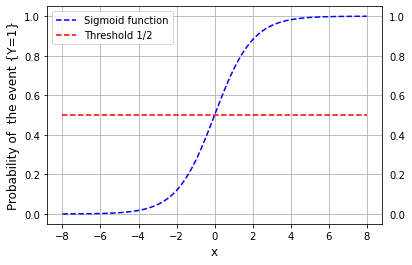

In [8]:
x = np.linspace(-8,8,100)
z = sigmoid(x)
plt.plot(x,z,linestyle = "dashed",color="blue", label= "Sigmoid function")
plt.plot(x,.5*np.ones(np.size(x)),linestyle = "dashed",color="red", label="Threshold 1/2")
plt.ylabel('Probability of  the event {Y=1}', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')
plt.legend();

Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle + b)\,,
\end{equation*}

The graph above illustrates that the Bayes classification rule in this case is
$f^*(X) = 1$ if and only if $\langle w,X \rangle + b>0$.

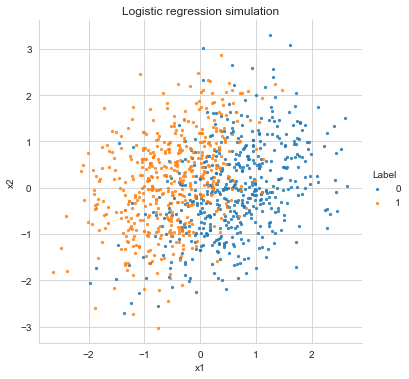

In [9]:
n_samples  = 1000
n_features = 2

w0   = multivariate_normal([-2,1], np.eye(2))

X, y = sample_logistic(w0, n_samples=n_samples, corr = 0.3)

simulated_data          = pd.DataFrame(columns = ["x","y","Label"])
simulated_data["x1"]     = X[:,0]
simulated_data["x2"]     = X[:,1]
simulated_data["Label"] = y

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

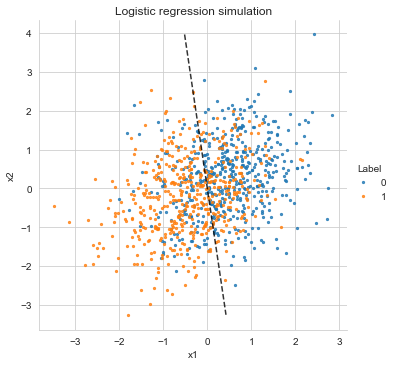

In [7]:
def decision_function(X,w):
    z = sigmoid(X.dot(w))
    return z
    
xlim  = [np.min(X[:,0]), np.max(X[:,0])]
ylim  = [np.min(X[:,1]), np.max(X[:,1])]
xplot = np.linspace(xlim[0], xlim[1], 30)
yplot = np.linspace(ylim[0], ylim[1], 30)

Yplot, Xplot = np.meshgrid(yplot, xplot)
xy           = np.vstack([Xplot.ravel(), Yplot.ravel()]).T
P            = decision_function(xy,w0).reshape(Xplot.shape)

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

# plot decision boundary and margins
plt.contour(Xplot, Yplot, P, colors = 'k', levels = [0.5], alpha = 0.8, linestyles = ['--']);

### <font color=darkred>  Logistic regression: losses and gradients </font>

The aim of this section is to detail how to solve the following optimization problem
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}\,,
$$
where $d$ is the number of features.

$$
f: w \mapsto \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \{-y_ix_i'w + \log(1 + \exp(x_i' w))\} + \frac{\lambda}{2} \|w\|_2^2\,,
$$
where $n$ is the sample size, and where $y_i \in \{ 0, 1 \}$ for all $1\leqslant i\leqslant n$.
 
A basic gradient descent algorithm requires to compute the functions $f$ and $\nabla f$.

<font color=darkred>  Write the likelihood of the logistic regression model and its gradient (blackboard)</font>

In [8]:
class LogisticRegression:
    def __init__(self, X, y, lmbd):
        self.X = X
        self.y = y
        self.lmbd = lmbd
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        # Computes f(w)
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        res = 0
        for k in range(n_samples):
            res += np.log(1+np.exp(X[k].dot(w))) - y[k]*X[k].dot(w)
        res = res/n_samples
        res += lmbd*0.5*(norm(w)**2)
        return res
    
    def grad(self, w):
        # Computes the gradient of f at w
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        res = 0
        for k in range(n_samples):
            res += -y[k]*X[k] + np.exp(X[k].dot(w))/(1+np.exp(X[k].dot(w)))*X[k]
        res = res/n_samples
        res += lmbd*w
        return res  

In [9]:
# Check numerically the gradient using the function checkgrad from scipy.optimize
# Use the function simu_logreg to simulate data according to the logistic regression model
n_features = 10
w_true     = np.random.randn(n_features)
X, y       = sample_logistic(w_true, n_samples, corr=0.9)
model      = LogisticRegression(X, y, 1e-3)
# check_grad assesses the correctness of a gradient by comparing it to a finite-difference approximation
check_grad(model.loss, model.grad, w_true)

7.715031069363636e-08

### <font color=darkred> Gradient descent </font>

In the case of machine/deep learning applications, the function to be minimized is of the form:
$$
f:w\mapsto  \frac{1}{n}\sum_{i=1}^n \ell(Y_i, \langle w; X_i \rangle) + \lambda g(w) = \frac{1}{n}\sum_{i=1}^n f_i(w)\,.
$$
The most simple method  is based on full gradients, since at each iteration  it requires to compute
$$
\nabla f(w) = \frac 1n \sum_{i=1}^n \nabla  f_i(w)\,,
$$
which depends on the whole dataset. When processing very large datasets ($n$ is large), this approach has a highly prohibitive computational cost  for a  unique step towards the minimum. 
For all $k\geqslant 1$, set
$$
w^{(k)} = w^{(k-1)} - \eta_k \nabla f_{}(w^{(k-1)})\,.
$$
Each iteration has complexity $O(nd)$.

In [10]:
def gd(model, w0, n_iter,step):
    loss_val = np.zeros(n_iter+1)
    w        = w0.copy()
    w_new    = w0.copy()
    for k in range(n_iter + 1):
        ## TO BE COMPLETED ##
        w_new[:]    = 
        w[:]        = w_new
        loss_val[k] = 
    return w, loss_val

In [11]:
step_sgd   = 1e-1
w0         = np.random.randn(n_features)
n_iter_max = 500

w, gd_loss  = gd(model, w0, n_iter = n_iter_max, step = step_sgd)

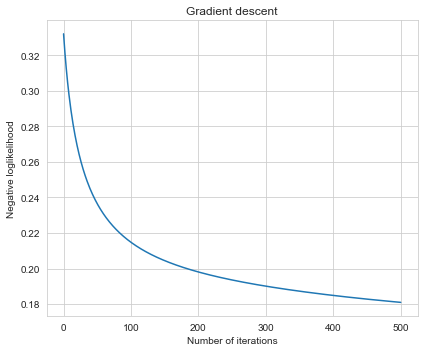

In [12]:
figure = plt.figure(figsize = (6, 5))
plt.plot(gd_loss, '-')
plt.title('Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()

### <font color=darkred> Roc curve and auc</font>

In [13]:
n_test = int(0.2*n_samples)
X_test, y_test = sample_logistic(w_true, n_samples = n_test, corr = 0.9)

In [14]:
# predicted class using the estimated model
y_pred = y_test.copy()
for i in range(n_test):
    if X_test[i].dot(w)>0:
        y_pred[i] = 1.0
    else:
        y_pred[i] = 0.0
print('Mean prediction error with the estimated parameter: %f'%np.mean(np.abs(y_pred-y_test)))

Mean prediction error with the estimated parameter: 0.075000


In [15]:
# predicted probability for each new individual using the estimated model
y_score = np.zeros(n_test)
for i in range(n_test):
    y_score[i] = sigmoid(X_test[i].dot(w))

The Receiver Operating Characteristic (ROC) curve assesses the diagnostic ability of the classifier  as the classification threshold is modified. Logistic regression models the distribution of $Y$ given $X$ as

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle + b)\,,
\end{equation*}

and the Bayes classifier is defined as 

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > \mathbb{P}(Y = 0| X)$,

which is equivalent to 

$f^*(X) = 1$ if and only if $\langle w,X \rangle + b>0$,

or also to 

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) >1/2$. 

Therefore, the theoretical threshold to classify individuals is $1/2$. However, analyzing the sensitivity of the classifier to this threshold may be interesting which is the aim of the ROC curve which displays the True positive rate as a function of the False positive rate when the threshold is changed. For each value $p^*\in(0,1)$ the ROC curve classifies individuals using

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > p^*$

and plots the True positive rate as a function of the False positive rate. 

Depending on the application, an optimal threshold may then be used to obtain satisfying True and False positive rates on the test data set.

In [16]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
thresholds

array([2.00e+00, 1.00e+00, 9.32e-01, 9.29e-01, 8.67e-01, 8.65e-01,
       7.51e-01, 6.97e-01, 6.57e-01, 5.64e-01, 5.37e-01, 5.24e-01,
       4.91e-01, 4.30e-01, 3.92e-01, 2.72e-01, 2.25e-01, 1.86e-01,
       1.85e-01, 6.43e-02, 6.13e-02, 4.57e-02, 4.45e-02, 5.60e-09])

In [25]:
print('Thresholds used to build the ROC curve: ',thresholds)

Thresholds used to build the ROC curve:  [2.00e+00 1.00e+00 9.32e-01 9.29e-01 8.67e-01 8.65e-01 7.51e-01 6.97e-01
 6.57e-01 5.64e-01 5.37e-01 5.24e-01 4.91e-01 4.30e-01 3.92e-01 2.72e-01
 2.25e-01 1.86e-01 1.85e-01 6.43e-02 6.13e-02 4.57e-02 4.45e-02 5.60e-09]


In [26]:
print('False positive rates: ',fpr)

False positive rates:  [0.   0.   0.   0.01 0.01 0.02 0.02 0.03 0.03 0.05 0.05 0.06 0.06 0.11
 0.11 0.18 0.18 0.19 0.19 0.34 0.34 0.39 0.39 1.  ]


In [27]:
print('True positive rates: ',fpr)

True positive rates:  [0.   0.   0.   0.01 0.01 0.02 0.02 0.03 0.03 0.05 0.05 0.06 0.06 0.11
 0.11 0.18 0.18 0.19 0.19 0.34 0.34 0.39 0.39 1.  ]


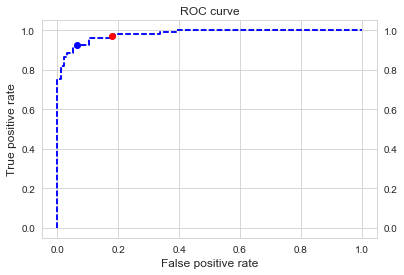

In [33]:
x = np.linspace(-8,8,100)
z = sigmoid(x)
plt.plot(fpr,tpr,linestyle = "dashed",color="blue")
plt.title('ROC curve')
plt.ylabel('True positive rate', fontsize=12)
plt.xlabel('False positive rate', fontsize=12)
plt.tick_params(labelright=True)
plt.plot(fpr,tpr,linestyle = "dashed",color="blue")
plt.plot(fpr[16],tpr[16],'o',color="red")
plt.plot(fpr[12],tpr[12],'o',color="blue")
plt.grid('True')

In [18]:
print('The area under the ROC curve (AUC) is: %f'%metrics.auc(fpr, tpr))

The area under the ROC curve (AUC) is: 0.981153


## <font color=darkred> Softmax regression </font>

Logistic regression can be extended to classify data in more than two groups. Softmax regression provides a model for the probability that an input $x$ is associated with each group.  It is assumed that the probability to belong to the class $k\in\{1,\ldots,M\}$ can be expressed by 
\begin{equation*}
\mathbb{P}(Y = k| X) = \frac{\exp(\langle w_k,X \rangle + b_k)}{\sum_{\ell=1}^{M}\exp(\langle w_\ell,X \rangle + b_\ell)} = p_k(X)\,,
\end{equation*}
where $w_\ell \in \mathbb{R}^d$ and $b_\ell$  are model \textbf{weights} and \textbf{intercepts} for each class.


To estimate these unknown parameters, a maximum likelihood approach is used as in the logistic regression setting. In this case, the loss function is given by the negative log-likelihood (see also the section on gradient based method).

<font color=darkred>  Write the likelihood of the softmax regression model and its gradient (blackboard)</font>

## <font color=darkred> Handwritten digit recognition with MNIST </font>

The MNIST (http://yann.lecun.com/exdb/mnist) dataset contains images representing handwritten digits.  Each input image is a 28 x 28 matrix, each entry representing a gray level.  Each input data is then a $d=784$ dimensional vector.  

The labels in $\{0, 1, 2, \ldots, 9\}$ can represented using one-hot encoding: labels in $\{0, 1, 2, \ldots, 9\}$ are replaced by labels in $\{ 0, 1\}^{10}$, namely $0$ is replaced by $(1, 0, \ldots 0)$, $1$ is replaced by $(0, 1, 0, \ldots 0)$, $2$ is replaced by $(0, 0, 1, 0, \ldots, 0)$, etc.

In [10]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations
#from keras import backend as K
# Number of classes
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train     = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test      = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# normalize the input data
x_train = x_train/255
x_test  = x_test/255

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)
60000 train samples
10000 test samples


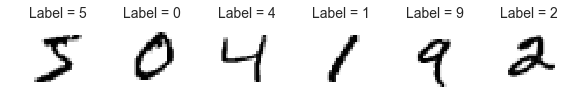

In [11]:
plt.figure(figsize=(8, 2))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap="gray_r")
    plt.title('Label = %d' % y_train[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()

In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

A softmax regression model can be designed and estimated using Keras as this model is a feed froward neural network with only one layer. Each input data $X$ is represented by a 784 dimensional vector and the first layer is made of $10$ neurons each one corresponding to one class and computing $p_k(X)$ for each $0\leqslant k\leqslant 9$.

In [13]:
# Create a model prone to add layers sequentially
model = Sequential()
# flatten the data replaces 28 * 28 matrices by a 784 dimensional vector
# This is always necessary before a fully-connected layer (Dense object)
model.add(Flatten(input_shape=input_shape, name='flatten'))
# add one dense (fully connected layer) with softmax activation function
# As it is the first layer, the input size is mandatory
model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))

# "compile" this model, 
model.compile(
    # specify the loss as the cross-entropy
    loss=keras.losses.categorical_crossentropy,
    # choose the gradient based method to estimate the parameters
    # see https://keras.io/optimizers/ to have an overview of the different options
    # see also section 2 on gradient based methods.
    optimizer=keras.optimizers.Adagrad(),
    # metric to monitor on the test data
    metrics=['accuracy']
)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [14]:
batch_size = 64
epochs = 25
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 2s 26us/step - loss: 0.4886 - acc: 0.8760 - val_loss: 0.3624 - val_acc: 0.9057
Epoch 2/25
60000/60000 [==============================] - 1s 22us/step - loss: 0.3608 - acc: 0.9025 - val_loss: 0.3308 - val_acc: 0.9116
Epoch 3/25
60000/60000 [==============================] - 1s 21us/step - loss: 0.3368 - acc: 0.9078 - val_loss: 0.3154 - val_acc: 0.9138
Epoch 4/25
60000/60000 [==============================] - 1s 22us/step - loss: 0.3241 - acc: 0.9111 - val_loss: 0.3072 - val_acc: 0.9155
Epoch 5/25
60000/60000 [==============================] - 1s 21us/step - loss: 0.3157 - acc: 0.9127 - val_loss: 0.3014 - val_acc: 0.9168
Epoch 6/25
60000/60000 [==============================] - 1s 22us/step - loss: 0.3095 - acc: 0.9144 - val_loss: 0.2967 - val_acc: 0.9172
Epoch 7/25
60000/60000 [==============================] - 1s 22us/step - loss: 0

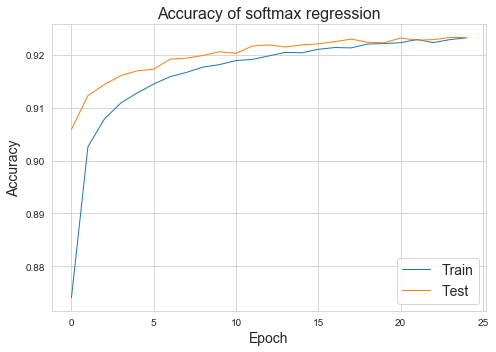

In [33]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=1, label='Train')
plt.plot(history.epoch, history.history['val_acc'], lw=1, label='Test')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

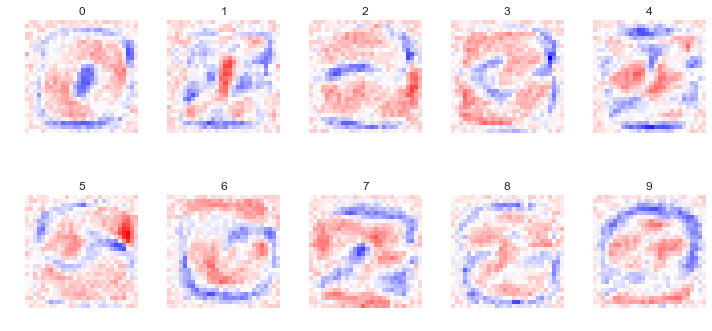

In [34]:
weights, biases = model.get_layer('dense_softmax').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='bwr')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()

### <font color=darkred> Feed-Forward Neural Network (FFNN) </font>

The softmax regression of the previous section is a linear model, with 7850 parameters.  It is easy to fit, numerically stable, but might be too simple for some tasks.  The idea underlying neural networks is to have successive "neurons" performing a linear transformation of the input data (depending on a weight matrix and a bia vector) followed by an activation function to design more flexible models with additional parameters.

In [35]:
# Create the graph for a fully connected feed-forward neural network with one hidden layer 
# with 128 units and a relu activation function. 

In [15]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape=input_shape))

## TO BE COMPLETED ##

model_ffnn.add(Dense(num_classes, activation='softmax'))

How many parameters are involved in this model ?

The input size is 28*28 = 724. 

This input is transformed linearly in 128 hidden units in the dense layer which lead to 128*784 + 128 = 100480 parameters to obtain the 128 units.

These units are transformed in a ``softmax`` activation function which adds 10*128 + 10 = 1290 parameters.

This Feed Forward Neural Networks depends on 101770 parameters !

In [ ]:
# Compile the model and display its summary

In [16]:
## TO BE COMPLETED ##

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [39]:
batch_size = 32
epochs = 25
history = model_ffnn.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))
score = model_ffnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 3s 53us/step - loss: 0.1356 - acc: 0.9621 - val_loss: 0.1348 - val_acc: 0.9619
Epoch 2/25
60000/60000 [==============================] - 3s 54us/step - loss: 0.1193 - acc: 0.9668 - val_loss: 0.1216 - val_acc: 0.9662
Epoch 3/25
60000/60000 [==============================] - 3s 54us/step - loss: 0.1077 - acc: 0.9704 - val_loss: 0.1151 - val_acc: 0.9669
Epoch 4/25
60000/60000 [==============================] - 3s 56us/step - loss: 0.0990 - acc: 0.9729 - val_loss: 0.1100 - val_acc: 0.9688
Epoch 5/25
60000/60000 [==============================] - 4s 59us/step - loss: 0.0921 - acc: 0.9752 - val_loss: 0.1031 - val_acc: 0.9698
Epoch 6/25
60000/60000 [==============================] - 4s 59us/step - loss: 0.0864 - acc: 0.9766 - val_loss: 0.1001 - val_acc: 0.9714
Epoch 7/25
60000/60000 [==============================] - 4s 59us/step - loss: 0.0816 - acc: 0.9779 - val_loss: 0.0976 - val_acc

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()